## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__)

4.11.0


## Загружаем исходные данные

In [34]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [35]:
# посмотрим на размерность
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# приводим размерность к удобному для обаботки виду
#train_img = np.resize(train_X[:, 1:], (train_X.shape[0], 28, 28)).astype('float64')
#test_img = np.resize(test_X, (test_X.shape[0], 28, 28)).astype('float64')

## Визуализируем исходные данные

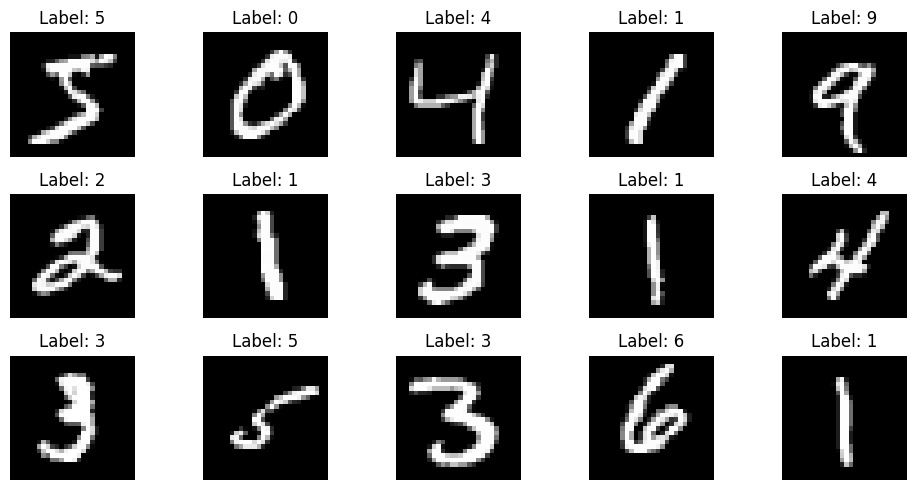

In [38]:
plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

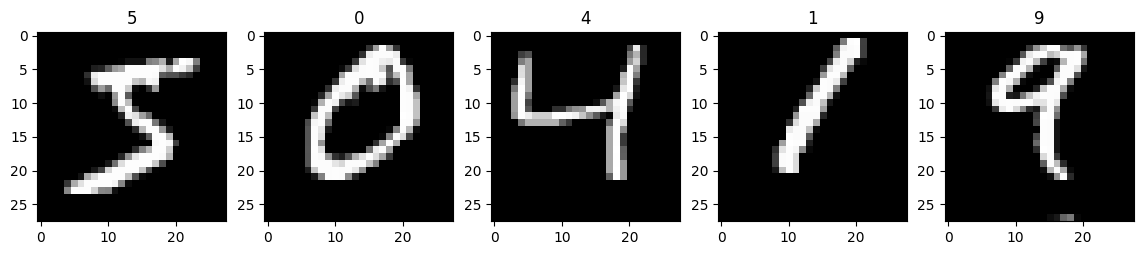

In [32]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);

## Вычисляем гистограммы градиентов

In [18]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [19]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
# зададим размер окна
ksize = 7

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
train_g.shape, train_theta.shape, type(train_g)

((60000, 28, 28), (60000, 28, 28), numpy.ndarray)

In [11]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [12]:
train_g.shape

(60000, 28, 28)

In [13]:
# соберем все вместе
X_train = cv2.merge([train_g[:::,], train_theta[:::,]])
X_test = cv2.merge((test_g, test_theta))
#X_train = train_theta
#X_test = test_theta
y_train = train_y
X_train.shape, X_test.shape, y_train.shape

SyntaxError: invalid syntax (<ipython-input-13-159cb81fa4ad>, line 2)

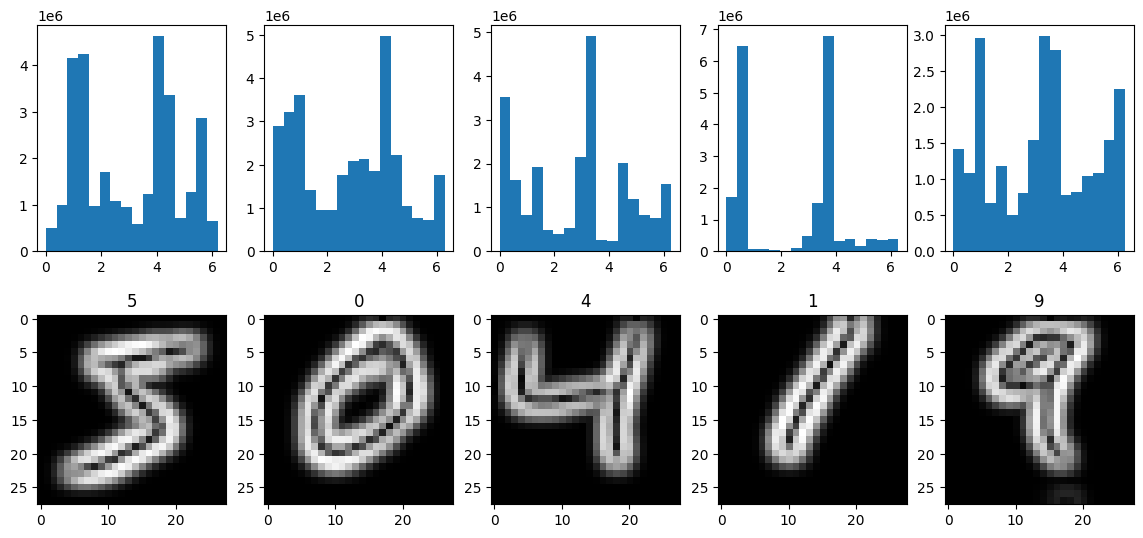

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Построим сеточку для распознавания

In [15]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers as L

In [ ]:
try:
  K.clear_session()
  del model
except:
  pass

# зададим входной слой
input_shape = L.Input(shape=(28,28))

# зададим 1-ю цепочку

# объединим
#merged = L.concatenate([way_1, way_2, way_3, way_4])
merged = L.Flatten()(input_shape)
out = L.BatchNormalization()(merged)

# добавим полносвязные слои
out = L.Dense(256, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(128, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(32, activation='relu')(out)
out = L.BatchNormalization()(out)
out = L.Dense(10, activation='softmax')(out)

# соберем модель
model = keras.Model(input_shape, out, name='My_model')

In [17]:
# посмотрим
model.summary()

Model: "My_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,114 (949.66 KB)

 Trainable params: 240,714 (940.29 KB)

 Non-trainable params: 2,400 (9.38 KB)

In [18]:
# зададим параметры
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['sparse_categorical_accuracy']   # для целочисленных меток
epochs = 32
learning_rate = 0.001
batch_size = 16
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# скомпилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# обучим модель
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=None,
          #callbacks=[reduce_lr],
          validation_split=0.2
)

Epoch 1/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 2.4212 - sparse_categorical_accuracy: 0.1013 - val_loss: 2.3197 - val_sparse_categorical_accuracy: 0.1013
Epoch 2/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 2.3060 - sparse_categorical_accuracy: 0.1146 - val_loss: 2.3087 - val_sparse_categorical_accuracy: 0.1024
Epoch 3/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 2.3062 - sparse_categorical_accuracy: 0.1083 - val_loss: 2.3109 - val_sparse_categorical_accuracy: 0.1041
Epoch 4/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 2.3041 - sparse_categorical_accuracy: 0.1137 - val_loss: 2.3086 - val_sparse_categorical_accuracy: 0.1028
Epoch 5/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1115 - val_loss: 2.3111 - val_sparse_categorical_accuracy: 0.1018
Epoch 6/32
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 2.3000 - sparse_categorical_accuracy: 0.1189 - val_loss: 2.3179 - val_sparse_categorical_acc

KeyboardInterrupt: 

## Разбиваем выборку на обучение и валидацию

In [20]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_y, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [22]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [23]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [24]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [26]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.10025


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.11      0.03      0.05      1175
           1       0.12      0.21      0.15      1322
           2       0.10      0.06      0.07      1174
           3       0.11      0.09      0.10      1219
           4       0.10      0.21      0.13      1176
           5       0.09      0.15      0.11      1104
           6       0.09      0.09      0.09      1177
           7       0.09      0.05      0.06      1299
           8       0.08      0.02      0.04      1160
           9       0.11      0.09      0.10      1194

    accuracy                           0.10     12000
   macro avg       0.10      0.10      0.09     12000
weighted avg       0.10      0.10      0.09     12000



In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[ 39 225  66  89 253 173 138  62  35  95]
 [ 40 283  84 118 238 202 131  80  33 113]
 [ 33 218  68  92 265 188 129  63  31  87]
 [ 40 236  60 104 232 228 115  67  31 106]
 [ 37 225  73  98 242 191 116  62  31 101]
 [ 31 243  61  82 217 171 114  63  35  87]
 [ 42 207  64 111 255 200 103  63  38  94]
 [ 31 272  52 109 281 209 144  60  35 106]
 [ 29 227  83  85 255 194 109  55  27  96]
 [ 32 239  70  78 254 202 108  69  36 106]]


## Предсказания на тестовыйх данных

In [29]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

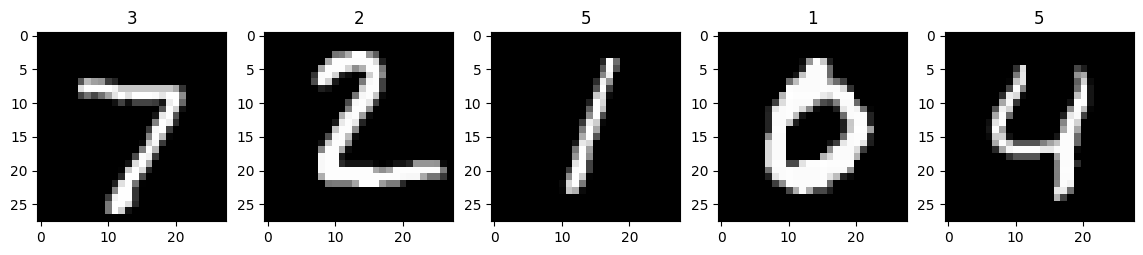

In [30]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700